<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/ATAC_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of ATAC-seq data and combined ATAC-seq/RNA-seq of Etv2 induced MEF reprogramming and ES/EB differentiation
by Wuming Gong



In [90]:
start_time0 <- Sys.time()

## Install R packages

### Install `gsl`, required by `DirichletMultinomial` and `chromVARmotifs`

In [91]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded."

In [92]:
install.packages(c('gsl', 'devtools'), Ncpus = 2)
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install(c(
  'chromVAR', 'BSgenome.Mmusculus.UCSC.mm10', 'motifmatchr', 'BiocParallel', 'SummarizedExperiment', 'gplots', 'circlize',
  'ComplexHeatmap', 'plyr', 'dplyr', 'DESeq2', 'VennDiagram', 'ggwordcloud'
), Ncpus = 2)
devtools::install_github("GreenleafLab/chromVARmotifs")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'chromVAR', 'BSgenome.Mmusculus.UCSC.mm10',
  'motifmatchr', 'BiocParallel', 'SummarizedExperiment', 'gplots', 'circlize',
  'ComplexHeatmap', 'plyr', 'dplyr', 'DESeq2', 'VennDiagram', 'ggwordcloud'

Old packages: 'broom', 'htmlwidgets', 'readr', 'foreign'

Skipping install of 'chromVARmotifs' from a github remote, the SHA1 (38bed559) has not changed since last install.
  Use `force = TRUE` to force installation



In [93]:
library(chromVARmotifs)
library(chromVAR)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(BiocParallel)
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(ComplexHeatmap)
register(MulticoreParam(4)) # Use 8 cores
library(plyr)
library(dplyr)
library(DESeq2)
library(VennDiagram)
library(ggwordcloud) 

## Read replicate-level ATAC-seq data

In [94]:
# Read the ATAC-seq read counts data for each sample and count the motifs at each interval
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/ATAC_peaks_Etv2_reprogramming.rds')))
se <- se[, colData(se)$group %in% c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos', 'MEF_NoDox', 'MEF_Dox_D1', 'MEF_Dox_D2', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')]
se <- se[rowSums(assays(se)$counts > 0) >= 2]
is_MEF <- colData(se)$group %in% c('MEF_NoDox', 'MEF_Dox_D1', 'MEF_Dox_D2', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')
is_EB <- colData(se)$group %in% c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos')
se

class: RangedSummarizedExperiment 
dim: 168305 16 
metadata(0):
assays(1): counts
rownames(168305): chr1 chr1 ... chrY chrY
rowData names(0):
colnames: NULL
colData names(9): study_accession run ... tissue bw_file

In [95]:
colData(se)$group %>% table()

.
        EB_Dox_D25 EB_Dox_D25_Flk1pos       EB_NoDox_D25         MEF_Dox_D1 
                 2                  2                  2                  2 
        MEF_Dox_D2         MEF_Dox_D7 MEF_Dox_D7_Flk1pos          MEF_NoDox 
                 2                  2                  2                  2 

## Read scRNA-seq of MEF reprogramming

In [96]:
se_sc <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds')))
table(colData(se_sc)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948        2936        7202         827 

## Find the DE genes between MEF D7 Flk1+ cells and undifferentiated MEF

In [97]:
X <- assays(se_sc)$scaled_counts
j_MEF_NoDox <- colData(se_sc)$group %in% 'MEF_NoDox'
j_MEF_Dox_D7_Flk1pos <- colData(se_sc)$group %in% c('MEF_Dox_D7b')
pvalues <- mclapply(
  1:nrow(X), 
  function(i) wilcox.test(X[i, j_MEF_Dox_D7_Flk1pos], X[i, j_MEF_NoDox])$p.value,
  mc.cores = 2
) %>% unlist()

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



## Read bulk RNA-seq of EB differentiation

In [98]:
se_bulk <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2RNA-seq_version=20190909a/se.rds')))

## Find  DE genes between no dox and Flk1+ cells post induction

In [99]:
se_bulk <- DESeqDataSet(se_bulk, design = ~ group)
se_bulk <- estimateSizeFactors(se_bulk)
se_bulk <- DESeq(se_bulk)
assays(se_bulk)$normalized_counts <- log2(counts(se_bulk, normalized = TRUE) + 1)
res <- results(se_bulk, contrast = c('group', 'EB_Dox_D25_Flk1pos_Etv2', 'EB_NoDox_D25_Etv2'))

Warning message in DESeqDataSet(se_bulk, design = ~group):
“some variables in design formula are characters, converting to factors”
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Merge the scRNA-seq and bulk RNA-seq by gene symbols.


In [100]:
d_rna_merge <- merge(
  data.frame(
    symbol = rownames(res), 
    EB_log2FoldChange = res$log2FoldChange, 
    EB_pvalue = res$pvalue
  ),
  data.frame(
    symbol = rowData(se_sc)$name, 
    MEF_log2FoldChange = rowMeans(X[, j_MEF_Dox_D7_Flk1pos]) - rowMeans(X[, j_MEF_NoDox]), 
    MEF_pvalue = pvalues
  ),
  by.x = 'symbol',
  by.y = 'symbol'
) %>%
  filter(!is.na(EB_pvalue) & !is.na(MEF_pvalue)) %>%
  filter(!duplicated(symbol))
rownames(d_rna_merge) <- d_rna_merge$symbol
d_rna_merge %>% filter(symbol %in% c('Etv2', 'Kdr', 'Emcn', 'Cdh5', 'Runx1'))

,symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cdh5,Cdh5,7.534863,1.315189e-43,1.5647330,0.000000e+00
Emcn,Emcn,5.908320,6.634402e-03,1.4578199,0.000000e+00
Etv2,Etv2,5.462880,0.000000e+00,1.1166636,3.666651e-272
Kdr,Kdr,7.093824,0.000000e+00,1.7277936,0.000000e+00
Runx1,Runx1,1.891086,1.139845e-11,-0.3865211,1.138801e-25


## chromVAR analysis of combined ATAC-seq data


In [101]:
data("mouse_pwms_v2") 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
motif_ix <- matchMotifs(mouse_pwms_v2, se, genome = 'mm10')

### Looking for significantly changed motifs in EB

In [102]:
valid <- rowSums(assays(se[, is_EB])$counts > 0) >= 2
dev_EB <- computeDeviations(object = se[valid, is_EB], annotations = motif_ix[valid, ])
v_EB <- computeVariability(dev_EB)

### Looking for significantly changed motifs in MEF

In [103]:
valid <- rowSums(assays(se[, is_MEF])$counts > 0) >= 2
dev_MEF <- computeDeviations(object = se[valid, is_MEF], annotations = motif_ix[valid, ])
v_MEF <- computeVariability(dev_MEF)

number of significantly changed motifs in EB: 717


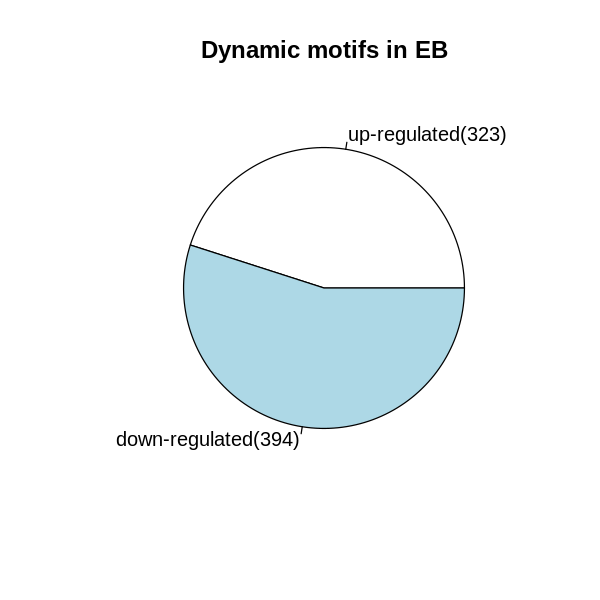

In [104]:
d_EB_Dox_D25_Flk1pos <- rowMeans(assays(dev_EB)$deviations[, colData(dev_EB)$group %in% c('EB_Dox_D25_Flk1pos')])
d_EB_NoDox_D25 <- rowMeans(assays(dev_EB)$deviations[, colData(dev_EB)$group %in% c('EB_NoDox_D25')])
n_EB_up <- sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25)
n_EB_down <- sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25)
cat(sprintf('number of significantly changed motifs in EB: %d\n', sum(v_EB$p_value_adj < 0.05)))
options(repr.plot.width=5, repr.plot.height=5)
pie(
  c(n_EB_up, n_EB_down), 
  labels = sprintf(c('up-regulated(%d)', 'down-regulated(%d)'), c(n_EB_up, n_EB_down)),
  main = "Dynamic motifs in EB"
)

number of significantly changed motifs in MEF: 744


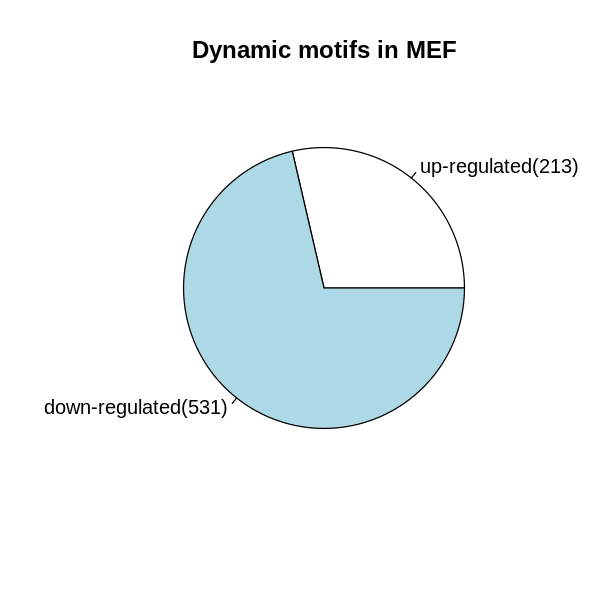

In [105]:
d_MEF_Dox_D7_Flk1pos <- rowMeans(assays(dev_MEF)$deviations[, colData(dev_MEF)$group %in% c('MEF_Dox_D7_Flk1pos')])
d_MEF_NoDox <- rowMeans(assays(dev_MEF)$deviations[, colData(dev_MEF)$group %in% c('MEF_NoDox')])
n_MEF_up <- sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox)
n_MEF_down <- sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox)
cat(sprintf('number of significantly changed motifs in MEF: %d\n', sum(v_MEF$p_value_adj < 0.05)))
options(repr.plot.width=5, repr.plot.height=5)
pie(
  c(n_MEF_up, n_MEF_down), 
  labels = sprintf(c('up-regulated(%d)', 'down-regulated(%d)'), c(n_MEF_up, n_MEF_down)),
  main = "Dynamic motifs in MEF"
)

(polygon[GRID.polygon.3051], polygon[GRID.polygon.3052], polygon[GRID.polygon.3053], polygon[GRID.polygon.3054], text[GRID.text.3055], text[GRID.text.3056], text[GRID.text.3057], text[GRID.text.3058], text[GRID.text.3059]) 

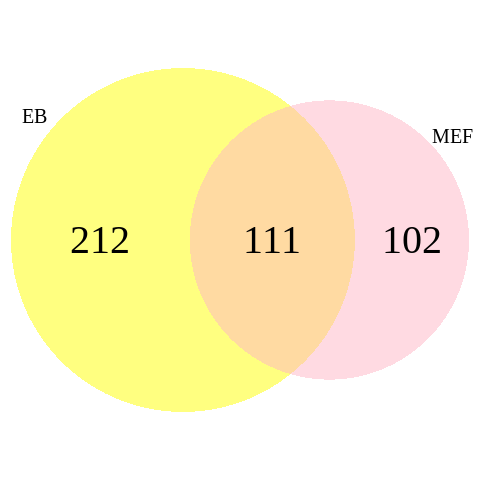

In [106]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25),
  area2 = sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox), 
  cross.area = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos > d_EB_NoDox_D25 & v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos > d_MEF_NoDox),
  category = c("EB", 'MEF'), 
  lty = "blank", 
  fill = c("yellow1", "pink1"),
  cex = 2,
  cat.cex = 1
)

(polygon[GRID.polygon.3060], polygon[GRID.polygon.3061], polygon[GRID.polygon.3062], polygon[GRID.polygon.3063], text[GRID.text.3064], text[GRID.text.3065], text[GRID.text.3066], text[GRID.text.3067], text[GRID.text.3068]) 

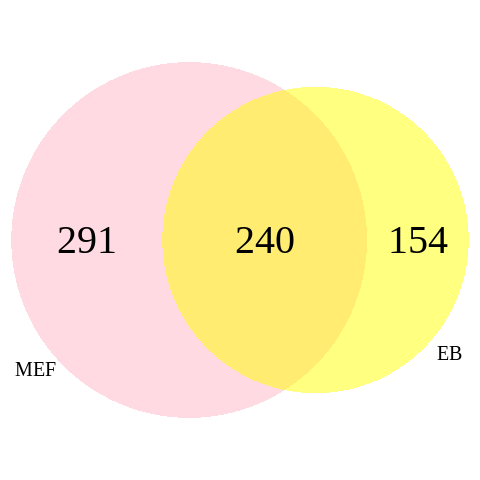

In [107]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25),
  area2 = sum(v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox), 
  cross.area = sum(v_EB$p_value_adj < 0.05 & d_EB_Dox_D25_Flk1pos < d_EB_NoDox_D25 & v_MEF$p_value_adj < 0.05 & d_MEF_Dox_D7_Flk1pos < d_MEF_NoDox),
  category = c("EB", 'MEF'), 
  lty = "blank", 
  fill = c("yellow1", "pink1"),
  cex = 2,
  cat.cex = 1
)

### PCA

In [108]:
data("homer_pwms") 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
motif_ix <- matchMotifs(homer_pwms, se, genome = 'mm10')
dev <- computeDeviations(object = se, annotations = motif_ix)
v <- computeVariability(dev)
v[grep('Etv2', v$name), ]

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967),Etv2(ETS),22.06789,13.86838,27.35646,0,0


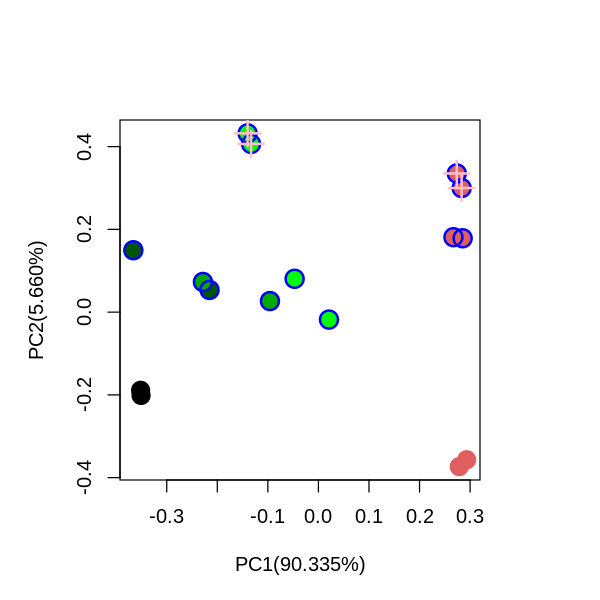

In [109]:
# Plot PCA of the motif deviations 
m <- v$p_value_adj < 0.05
s <- prcomp(assays(dev)$z[m, ])
eigs <- s$sdev^2

colData(se)$cell <- gsub('(.+?)_.+', '\\1', colData(se)$group)
colData(se)$dox <- rep("Dox", ncol(se))
colData(se)$dox[grep('NoDox', colData(se)$group)] <- 'NoDox'
MEF_cols <- colorpanel(4, low = 'black', high = 'green')
EB_cols <- colorpanel(3, low = 'gray', high = 'red')
group2col <- c(
  'MEF_NoDox' = MEF_cols[1],
  'MEF_Dox_D1' = MEF_cols[2],
  'MEF_Dox_D2' = MEF_cols[3],
  'MEF_Dox_D7' = MEF_cols[4],
  'MEF_Dox_D7_Flk1pos' = MEF_cols[4],

  'EB_NoDox_D0' = EB_cols[1],
  'EB_NoDox_D25' = EB_cols[2],
  'EB_NoDox_D3' = EB_cols[3],
  'EB_NoDox_D3_Flk1pos' = EB_cols[3],

  'EB_Dox_D0' = EB_cols[1],
  'EB_Dox_D25' = EB_cols[2],
  'EB_Dox_D25_Flk1pos' = EB_cols[2],
  'EB_Dox_D3' = EB_cols[3],
  'EB_Dox_D3_Flk1pos' = EB_cols[3]
)
is_flk1pos <- grepl('Flk1pos', colData(se)$group)
is_dox <- grepl('_Dox_', colData(se)$group)
pc_x <- 1; pc_y <- 2

par(mar = c(5, 5, 5 , 5))
options(repr.plot.width=5, repr.plot.height=5)
plot(s$rotation[, pc_x], s$rotation[, pc_y], pch = 21, bg = group2col[colData(se)$group], col = group2col[colData(se)$group], cex = 2, xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100))
points(s$rotation[is_dox, pc_x], s$rotation[is_dox, pc_y], pch = 21, col = 'blue', cex = 2, lwd = 2)
points(s$rotation[is_flk1pos, pc_x], s$rotation[is_flk1pos, pc_y], pch = 3, col = 'pink', cex = 2, lwd = 2)

## Prepare data frame that includes EB/MEF and RNA-seq/motif information


In [110]:
head(d_rna_merge)

,symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0610005C13Rik,0610005C13Rik,2.2176660,0.003103568,0.01211949,3.800684e-02
0610009B22Rik,0610009B22Rik,0.1199313,0.512962604,0.65405450,3.036480e-11
0610009O20Rik,0610009O20Rik,0.1195349,0.294842818,-0.15085049,1.388946e-11
0610010F05Rik,0610010F05Rik,0.1665818,0.290078194,-0.61464126,7.809837e-55
0610010K14Rik,0610010K14Rik,-0.4331971,0.001113826,-0.16765820,1.543557e-17
0610012G03Rik,0610012G03Rik,-0.4166797,0.027842812,-0.14158193,4.620563e-06


In [111]:
d_motif <- data.frame(
  symbol = v_MEF$name,
  MEF_motif_diff = d_MEF_Dox_D7_Flk1pos - d_MEF_NoDox,
  MEF_motif_pvalue = v_MEF$p_value_adj,
  EB_motif_diff = d_EB_Dox_D25_Flk1pos - d_EB_NoDox_D25,
  EB_motif_pvalue = v_EB$p_value_adj
)
head(d_motif)

,symbol,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000021359_LINE1_Tcfap2a_D_N1,Tcfap2a,-0.04957349,1.028777e-30,-0.0166960331,2.346254e-11
ENSMUSG00000025927_LINE5_Tcfap2b_D,Tcfap2b,-0.02864240,6.240008e-04,-0.0032720884,4.018985e-02
ENSMUSG00000028640_LINE6_Tcfap2c_D,Tcfap2c,-0.04172174,1.260763e-20,-0.0006906132,1.460959e-03
ENSMUSG00000042477_LINE7_Tcfap2e_D,Tcfap2e,-0.03594847,1.312154e-03,-0.0275019741,5.187801e-13
ENSMUSG00000042596_LINE8_Tcfap2d_I,Tcfap2d,0.03562720,5.698099e-68,-0.0222458444,1.718045e-68
ENSMUSG00000004661_LINE10_Arid3b_D,Arid3b,-0.02118482,7.023209e-04,-0.0085091434,4.462344e-01


In [112]:
d_merge <- merge(d_rna_merge, d_motif, by.x = 'symbol', by.y = 'symbol')
d_merge %>% filter(symbol == 'Etv2')

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Etv2,5.46288,0,1.116664,3.666651e-272,0.3726517,0,0.3166992,0


## Commonly up-regulated TFs in EB


(polygon[GRID.polygon.3069], polygon[GRID.polygon.3070], polygon[GRID.polygon.3071], polygon[GRID.polygon.3072], text[GRID.text.3073], text[GRID.text.3074], text[GRID.text.3075], text[GRID.text.3076], text[GRID.text.3077]) 

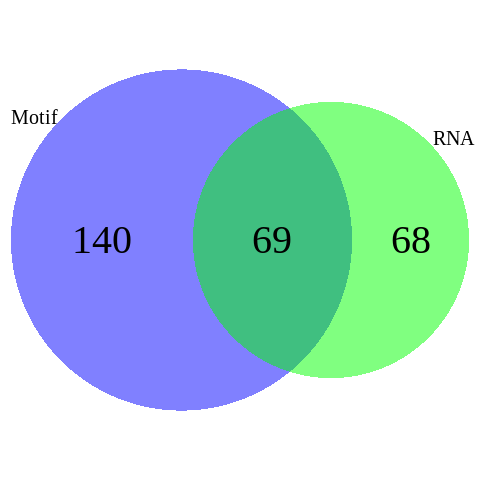

In [113]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0),
  area2 = sum(d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  cross.area = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0 & d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)

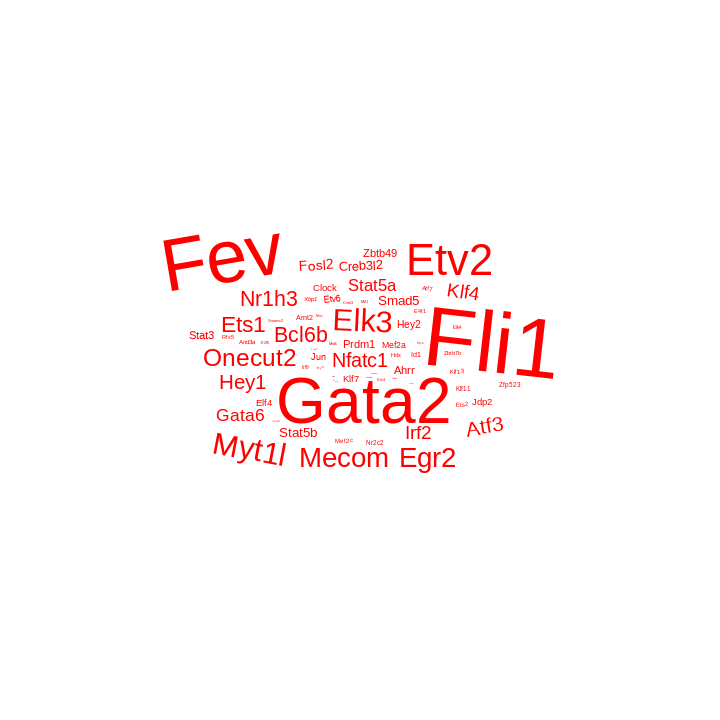

In [114]:
g <- d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff > 0 & EB_pvalue < 0.05 & EB_log2FoldChange > 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(g$EB_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
ggwordcloud2(df, color = 'red')

## Commonly up-regulated TFs in MEF

(polygon[GRID.polygon.3505], polygon[GRID.polygon.3506], polygon[GRID.polygon.3507], polygon[GRID.polygon.3508], text[GRID.text.3509], text[GRID.text.3510], text[GRID.text.3511], text[GRID.text.3512], text[GRID.text.3513]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ar,1.91818995,2.339774e-07,0.30181526,1.305945e-02,0.0889380956,9.748458e-14,0.009047035,1.900499e-01
Elk1,0.13196628,2.763154e-01,0.06724421,1.974680e-03,0.0053317010,1.958395e-117,0.074653506,2.534290e-77
Elk3,3.89322129,7.293291e-176,0.64554017,2.629787e-28,0.0057695094,1.764944e-132,0.074034224,2.057069e-75
Erf,0.17156413,1.042432e-01,0.00561777,3.136392e-09,0.2428089268,0.000000e+00,0.231551269,0.000000e+00
Etv2,5.46287962,0.000000e+00,1.11666357,3.666651e-272,0.3726516895,0.000000e+00,0.316699203,0.000000e+00
Fev,9.34336647,1.459927e-10,0.07294158,3.652266e-07,0.0983709801,6.707623e-180,0.144905000,7.091941e-272
Fli1,10.82302145,5.097621e-83,0.32156639,8.789963e-03,0.1051236767,4.164087e-194,0.150943246,0.000000e+00
Foxo1,-0.04173841,7.448086e-01,0.74523012,5.050680e-63,0.0470970014,1.273312e-19,0.061607575,5.184423e-77
Hic1,-1.93070041,7.558882e-02,0.35028880,8.806095e-06,0.0204700767,1.264748e-21,-0.062317390,1.177686e-67


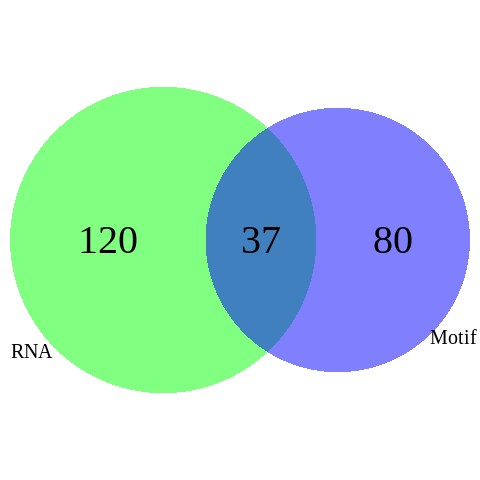

In [115]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0),
  area2 = sum(d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  cross.area = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0 & d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff > 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange > 0)

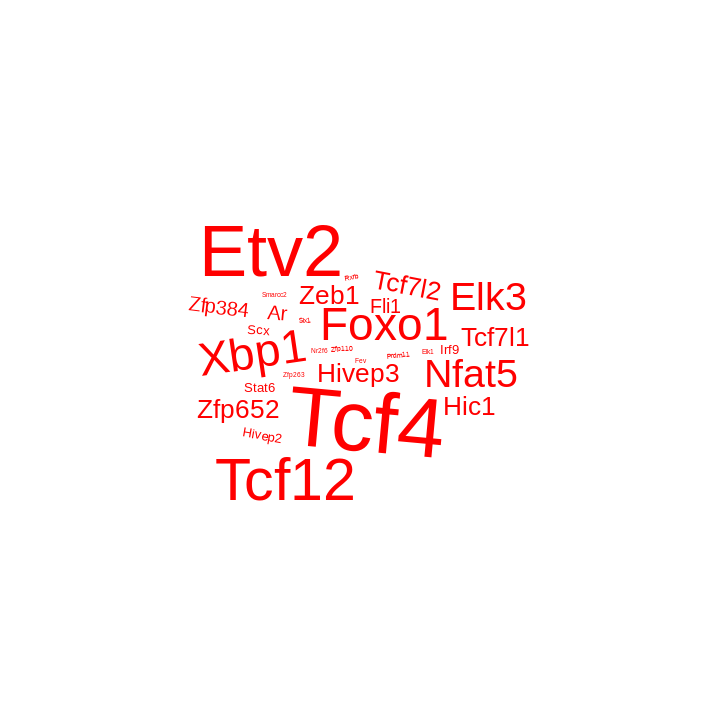

In [116]:
g <- d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff > 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange > 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(g$MEF_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
ggwordcloud2(df, color = 'red')


## Commonly down-regulated TFs in EB

(polygon[GRID.polygon.3765], polygon[GRID.polygon.3766], polygon[GRID.polygon.3767], polygon[GRID.polygon.3768], text[GRID.text.3769], text[GRID.text.3770], text[GRID.text.3771], text[GRID.text.3772], text[GRID.text.3773]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Arid5b,-0.9613975,1.627464e-04,-0.433185218,2.184590e-39,-0.0115374935,8.584294e-01,-0.114775819,8.536561e-17
Dbp,-1.5129366,3.682397e-07,0.369605676,4.342885e-23,-0.0841302031,4.217401e-01,-0.022167799,5.853427e-04
Dlx2,-3.7050465,3.185797e-02,-0.371028775,7.234171e-19,-0.0898862467,2.601125e-21,-0.104116193,4.135106e-22
Dnajc21,-1.3965521,1.450235e-25,-0.459882998,9.338145e-44,0.0199797428,2.003700e-28,-0.012718320,1.201780e-60
En1,-4.2319297,4.529304e-05,0.061860133,4.596258e-03,0.0324285922,9.890477e-01,-0.043979916,2.832358e-27
Eomes,-3.4036983,4.660843e-188,-0.175532802,9.318090e-05,-0.0330395167,1.309126e-09,-0.149383015,0.000000e+00
Foxa2,-5.3567505,1.593324e-44,-0.033782989,9.470553e-02,-0.0580592533,6.733701e-35,-0.088336455,1.654128e-54
Foxc1,-1.0402297,2.641499e-02,0.169467793,1.646391e-03,-0.0957602089,5.859636e-153,-0.029725702,2.710199e-07
Foxk2,-0.3424798,2.793676e-04,-0.334041905,9.428383e-32,-0.0534686927,2.600290e-24,-0.021533335,1.183073e-03


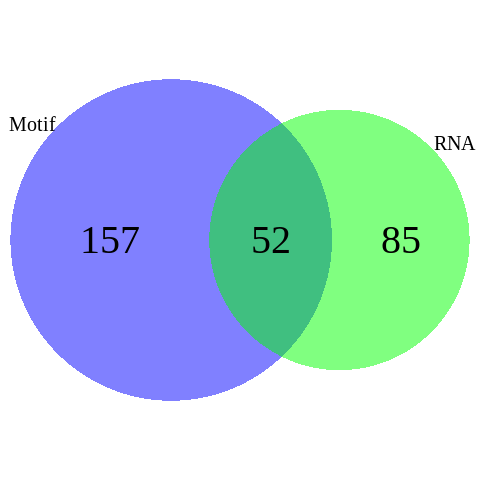

In [117]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff > 0),
  area2 = sum(d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange > 0),
  cross.area = sum(d_merge$EB_motif_pvalue < 0.05 & d_merge$EB_motif_diff < 0 & d_merge$EB_pvalue < 0.05 & d_merge$EB_log2FoldChange < 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff < 0 & EB_pvalue < 0.05 & EB_log2FoldChange < 0)

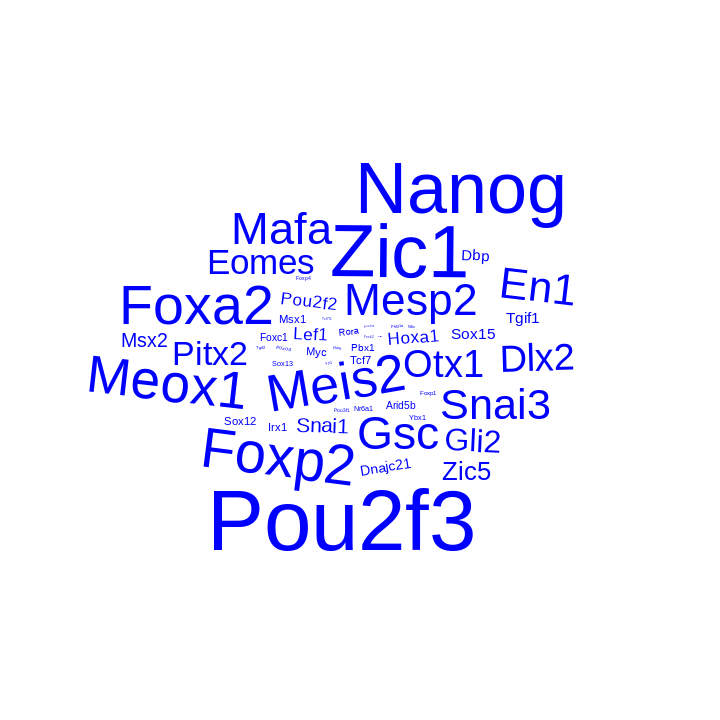

In [118]:
g <- d_merge %>% filter(EB_motif_pvalue < 0.05 & EB_motif_diff < 0 & EB_pvalue < 0.05 & EB_log2FoldChange < 0)
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(-g$EB_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
ggwordcloud2(df, color = 'blue')


## Commonly down-regulated TFs in MEF

(polygon[GRID.polygon.4099], polygon[GRID.polygon.4100], polygon[GRID.polygon.4101], polygon[GRID.polygon.4102], text[GRID.text.4103], text[GRID.text.4104], text[GRID.text.4105], text[GRID.text.4106], text[GRID.text.4107]) 

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ahctf1,-0.37710523,2.513277e-03,-0.58092264,1.754755e-54,-0.031128703,2.391511e-21,0.024677188,7.862684e-12
Arid3b,-1.45908668,7.382937e-55,-0.12304407,6.536180e-05,-0.021184824,7.023209e-04,-0.008509143,4.462344e-01
Arid5a,-0.55322854,2.777540e-01,-0.06833474,3.157943e-04,-0.041486349,1.050402e-08,-0.005389422,7.556459e-01
Arnt2,0.93608919,3.395964e-13,-0.05917111,1.071388e-04,-0.062616888,7.150475e-45,0.010889082,1.115220e-02
Cdc5l,-0.03067072,7.916518e-01,-0.05192568,2.329300e-08,-0.031230762,1.177500e-08,-0.060658252,2.450949e-13
Cic,-0.07215650,4.952031e-01,-0.04032786,4.494781e-10,-0.127530964,1.655911e-91,-0.027744198,1.644952e-06
Crem,-0.12784665,6.603090e-01,-0.02167471,1.199591e-07,-0.027324362,6.878637e-37,0.100274199,1.400868e-34
Ctcf,-0.07836705,4.731392e-01,-0.24921409,1.139491e-24,-0.004199994,1.056963e-97,-0.029729524,4.768477e-54
Dlx1,4.30839003,6.183562e-02,-0.31065543,9.719257e-16,-0.032896258,8.821181e-29,-0.048152239,1.529476e-29


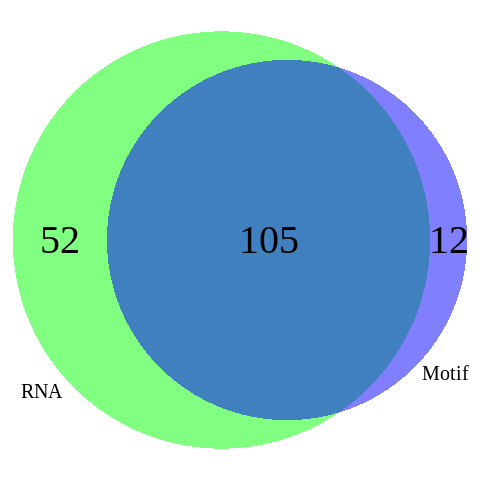

In [119]:
options(repr.plot.width=4, repr.plot.height=4)
draw.pairwise.venn(
  area1 = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff > 0),
  area2 = sum(d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange > 0),
  cross.area = sum(d_merge$MEF_motif_pvalue < 0.05 & d_merge$MEF_motif_diff < 0 & d_merge$MEF_pvalue < 0.05 & d_merge$MEF_log2FoldChange < 0),
  category = c("Motif", 'RNA'), 
  lty = "blank", 
  fill = c("blue", "green"),
  cex = 2,
  cat.cex = 1
)
d_merge %>% filter(MEF_motif_pvalue < 0.05 & MEF_motif_diff < 0 & MEF_pvalue < 0.05 & MEF_log2FoldChange < 0)

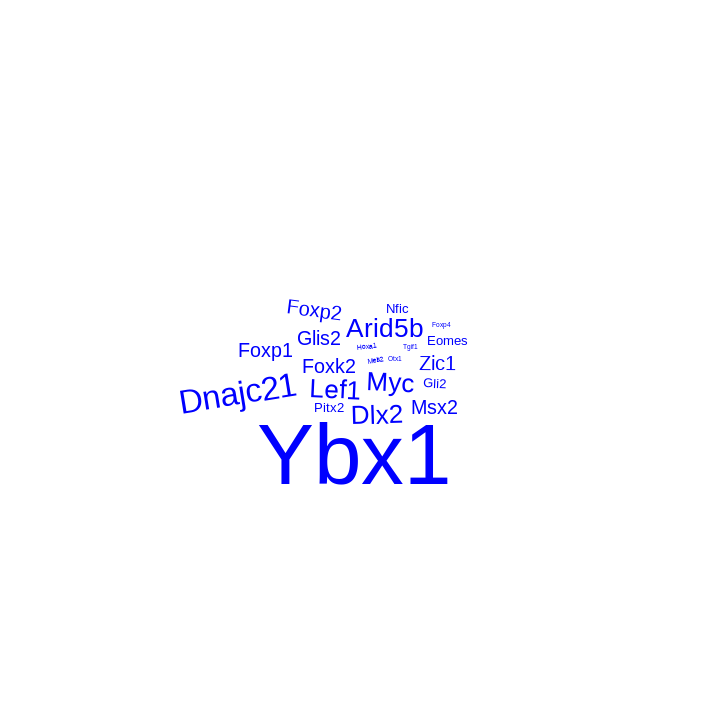

In [120]:
set.seed(1)
df <- data.frame(
  word = g$symbol,
  freq = round(-g$MEF_log2FoldChange * 10)
)
options(repr.plot.width=6, repr.plot.height=6)
ggwordcloud2(df, color = 'blue')

## A set of heatmaps that include commonly up- and down-regulated TFs in both MEF and EB

In [121]:
d_common <- d_merge %>%
  filter(
    (EB_pvalue < 0.05 & MEF_pvalue < 0.05) & 
    ( 
      (MEF_log2FoldChange < 0 & EB_log2FoldChange < 0 & MEF_motif_diff < 0 & EB_motif_diff < 0) |
      (MEF_log2FoldChange > 0 & EB_log2FoldChange > 0 & MEF_motif_diff > 0 & EB_motif_diff > 0)
    )
  ) %>% 
  mutate(symbol = as.character(symbol)) %>%
  arrange(desc(EB_log2FoldChange))
d_common

symbol,EB_log2FoldChange,EB_pvalue,MEF_log2FoldChange,MEF_pvalue,MEF_motif_diff,MEF_motif_pvalue,EB_motif_diff,EB_motif_pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Fli1,10.8230215,5.097621e-83,0.32156639,8.789963e-03,0.105123677,4.164087e-194,0.150943246,0.000000e+00
Fev,9.3433665,1.459927e-10,0.07294158,3.652266e-07,0.098370980,6.707623e-180,0.144905000,7.091941e-272
Etv2,5.4628796,0.000000e+00,1.11666357,3.666651e-272,0.372651689,0.000000e+00,0.316699203,0.000000e+00
Elk3,3.8932213,7.293291e-176,0.64554017,2.629787e-28,0.005769509,1.764944e-132,0.074034224,2.057069e-75
Myt1l,3.8699385,4.340639e-08,0.01211397,3.800684e-02,0.168200743,1.022668e-268,0.040247777,6.283454e-14
Ar,1.9181900,2.339774e-07,0.30181526,1.305945e-02,0.088938096,9.748458e-14,0.009047035,1.900499e-01
Prdm11,1.4644595,1.509044e-03,0.13141361,4.613107e-02,0.062620406,1.194713e-05,0.027014997,1.829317e-01
Prdm1,1.4226784,1.537160e-09,0.08493177,3.919664e-08,0.003572793,6.243144e-01,0.009652443,4.995683e-03
Xbp1,0.7029344,1.363983e-09,0.69708732,1.384014e-20,0.005287173,9.556940e-11,0.062764058,4.418816e-12


### Bulk RNA-seq in EB

In [122]:
n <- rowData(se_bulk)$refseq_mrna %in% d_common$symbol
cn <- c('EB_NoDox_D25_Etv2', 'EB_Dox_D25_Etv2', 'EB_Dox_D25_Flk1pos_Etv2')
m <- which(colData(se_bulk)$group %in% cn)
m <- m[order(factor(colData(se_bulk)$group[m], cn))]
is_flk1pos <- grepl('Flk1pos', colData(se_bulk)$group)
is_dox <- grepl('_Dox_', colData(se_bulk)$group)
X_bulk <- assays(se_bulk[n, m])$normalized_counts %>%
  t() %>%
  scale() %>%
  t()
rownames(X_bulk) <- rowData(se_bulk)$refseq_mrna[n]
X_bulk <- X_bulk[d_common$symbol, ]
X_bulk

Fli1,-1.17367216,-1.3787353,0.4784410,0.495934002,0.7604422,0.8175903
Fev,-1.15816833,-1.4135099,0.6530283,0.577199575,0.6453674,0.6960830
Etv2,-1.32616064,-1.2525618,0.6125626,0.581580263,0.7062182,0.6783614
Elk3,-1.29834803,-1.2831519,0.6293834,0.678193811,0.6492836,0.6246391
Myt1l,-1.06514624,-1.3810735,0.2703608,0.360764705,0.6756317,1.1394627
Ar,-0.90751815,-1.5719330,0.4975014,0.580726726,0.4370081,0.9642149
Prdm11,-0.63693237,-1.0811322,0.6244551,-0.941431362,0.8193571,1.2156838
Prdm1,-1.15982279,-1.3373156,0.6296863,0.176588784,0.9132562,0.7776071
Xbp1,-0.86278005,-1.5637637,0.3062706,0.328076428,0.9337361,0.8584606
Irf9,-0.81861511,-0.2128386,-0.6618283,-0.817977807,1.1455129,1.3657470
Smarcc2,-1.66928329,-0.6708307,0.3917141,0.202811797,0.7221819,1.0234062


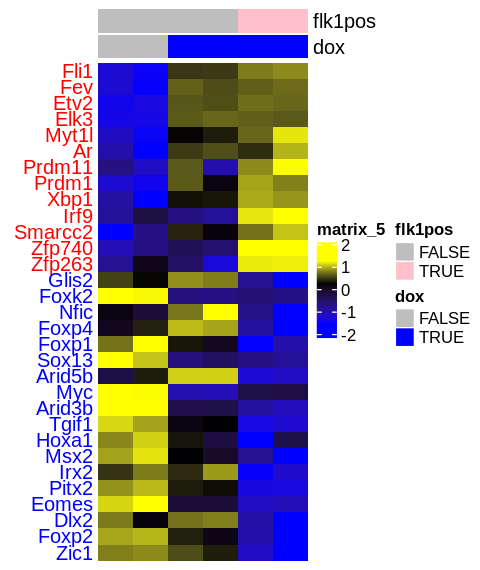

In [123]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
mark_col <- rep('red', nrow(X_bulk))
mark_col[rownames(X_bulk) %in% d_common[d_common$MEF_log2FoldChange < 0, 'symbol']] <- 'blue'
col_fun <- colorRamp2(quantile(X_bulk, c(0.05, 0.5, 0.95)), c("blue", "black", "yellow"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  X_bulk,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = TRUE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE,
  row_names_side = "left",
  row_names_gp = gpar(col = mark_col)
)

### scRNA-seq in MEF

In [124]:
n <- rowData(se_sc)$name %in% d_common$symbol
cn <- c('MEF_NoDox', 'MEF_Dox_D7a', 'MEF_Dox_D7b')
m <- which(colData(se_sc)$group %in% cn)
m <- m[order(factor(colData(se_sc)$group[m], cn))]
is_flk1pos <-  colData(se_sc)$group == 'MEF_Dox_D7b'
is_dox <- colData(se_sc)$group != 'MEF_NoDox'
X_sc <- assays(se_sc[n, m])$scaled_counts
rownames(X_sc) <- rowData(se_sc)$name[n]
X_sc <- X_sc[d_common$symbol, ]
X_sc[1:10, 1:10]

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



Fli1,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421,-0.22694421
Fev,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135,-0.05378135
Etv2,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880,-0.51605880
Elk3,1.22651495,-1.05472462,0.50385770,1.24119694,-1.05472462,0.69004071,-0.26701935,-1.05472462,0.54478684,-1.05472462
Myt1l,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622,-0.01825622
Ar,-0.55153063,-0.55153063,0.69599303,0.91920213,-0.55153063,-0.55153063,1.79446411,-0.55153063,0.73411920,-0.55153063
Prdm11,-0.17685146,-0.17685146,-0.17685146,2.54272532,-0.17685146,-0.17685146,-0.17685146,-0.17685146,-0.17685146,-0.17685146
Prdm1,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167,-0.03408167
Xbp1,-0.76685306,-0.76685306,-0.76685306,-0.76685306,0.79275655,-0.76685306,-0.76685306,-0.76685306,0.35640309,-0.76685306
Irf9,-0.27153399,-0.27153399,-0.27153399,-0.27153399,-0.27153399,-0.27153399,1.88682258,-0.27153399,-0.27153399,-0.27153399


`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` arugment by explicitly
setting TRUE/FALSE to it. Set `ht_opt$message = FALSE` to turn off this
message.



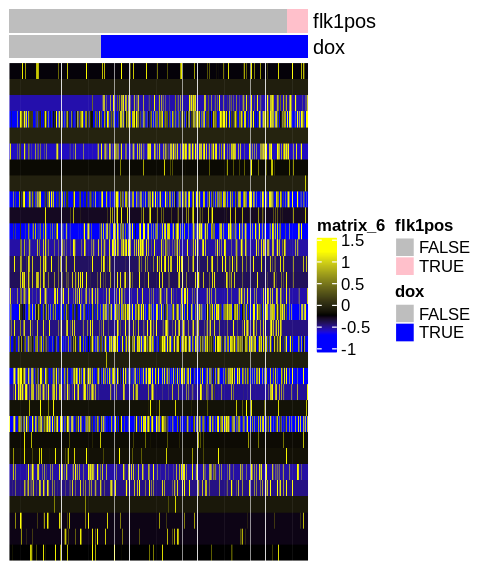

In [125]:
column_annotation <- HeatmapAnnotation(  
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(X_sc, c(0.1, 0.5, 0.9)), c("blue", "black", "yellow"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  X_sc,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

### ATAC-seq in EB

In [126]:
n <- rowData(dev_EB)$name %in% d_common$symbol
cn <- c('EB_NoDox_D25', 'EB_Dox_D25', 'EB_Dox_D25_Flk1pos')
m <- which(colData(dev_EB)$group %in% cn)
m <- m[order(factor(colData(dev_EB)$group[m], cn))]
is_flk1pos <- grepl('Flk1pos', colData(dev_EB)$group)
is_dox <- grepl('_Dox_', colData(dev_EB)$group)
Y_EB <- assays(dev_EB[n, m])$deviations 
rownames(Y_EB) <- rowData(dev_EB)$name[n]
Y_EB <- Y_EB[d_common$symbol, ]
Y_EB

Fli1,-9.048501e-02,-0.088729494,3.572340e-02,0.0458206106,0.051742200,0.0709297872
Fev,-8.845940e-02,-0.085099659,3.329231e-02,0.0484298586,0.047747880,0.0685030647
Etv2,-1.911624e-01,-0.198110640,9.166390e-02,0.1069753678,0.116837116,0.1272882286
Elk3,-4.484133e-02,-0.039186589,1.210762e-02,0.0202779911,0.018744254,0.0452962713
Myt1l,-2.464906e-02,-0.016533244,2.305638e-03,0.0041067219,0.024063885,0.0152493649
Ar,-5.127143e-03,-0.009663627,7.666046e-03,0.0060176961,0.002271559,0.0010317407
Prdm11,-1.525453e-02,-0.011773713,5.899472e-03,-0.0025733443,0.012949040,0.0140527087
Prdm1,-4.423152e-03,-0.003846863,-1.426947e-03,-0.0005009286,0.006295246,0.0047396247
Xbp1,-2.526358e-02,-0.028260665,-1.034855e-02,-0.0017404821,0.032870562,0.0391333110
Irf9,-1.769004e-02,-0.016592815,1.745631e-03,-0.0041980295,0.021862142,0.0186695695
Smarcc2,-2.734976e-02,-0.028487467,9.629734e-03,0.0039102380,0.015577684,0.0348061058


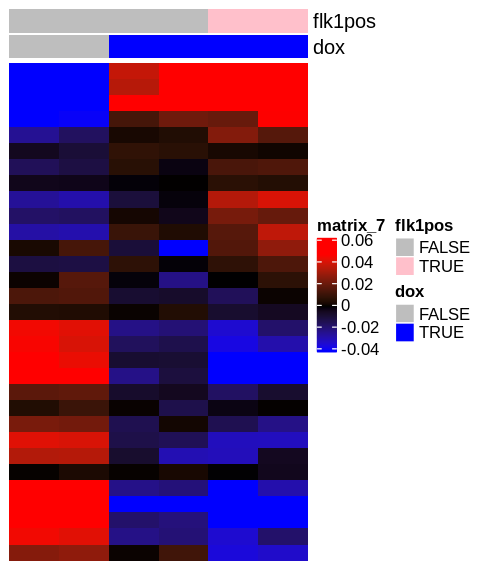

In [127]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(Y_EB, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  Y_EB,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

### ATAC-seq in MEF

In [128]:
n <- rowData(dev_MEF)$name %in% d_common$symbol
cn <- c('MEF_NoDox', 'MEF_Dox_D7', 'MEF_Dox_D7_Flk1pos')
m <- which(colData(dev_MEF)$group %in% cn)
m <- m[order(factor(colData(dev_MEF)$group[m], cn))]
is_flk1pos <- grepl('Flk1pos', colData(dev_MEF)$group)
is_dox <- grepl('_Dox_', colData(dev_MEF)$group)
Y_MEF <- assays(dev_MEF[n, m])$deviations 
rownames(Y_MEF) <- rowData(dev_MEF)$name[n]
Y_MEF <- Y_MEF[d_common$symbol, ]
Y_MEF

Fli1,0.002053046,-0.0355452668,-0.113588067,-0.029039253,0.0794752659,0.097279866
Fev,0.009946689,-0.0345437741,-0.121645794,-0.033671780,0.0732346291,0.098910246
Etv2,-0.140637772,-0.1581268992,-0.147535948,-0.046436384,0.2148478416,0.231690866
Elk3,0.057919976,0.0126245832,-0.101115349,-0.019354948,0.0353799333,0.046703644
Myt1l,-0.137974617,-0.0879581839,0.176127867,0.094959053,0.0628452935,0.047623392
Ar,-0.071643232,-0.0452916568,0.076119575,0.032787902,0.0298222173,0.031119086
Prdm11,0.005333840,-0.0359909825,-0.009098787,0.029679379,0.0494447195,0.045138950
Prdm1,-0.008783911,-0.0049999729,0.015339016,0.012367421,-0.0039400213,-0.002698277
Xbp1,0.043280217,0.0175949502,-0.056860768,-0.009943971,0.0247699534,0.046679561
Irf9,0.019098508,-0.0043903277,-0.028957196,0.016146381,0.0220582078,0.049882706
Smarcc2,-0.010818664,0.0008824015,-0.008140677,0.011878177,0.0041643855,0.008845639


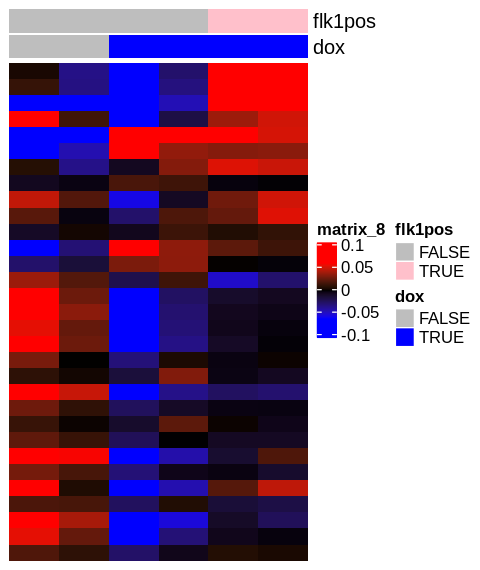

In [129]:
column_annotation <- HeatmapAnnotation(
  flk1pos = is_flk1pos[m],
  dox = is_dox[m],
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray')
  )
)
col_fun <- colorRamp2(quantile(Y_MEF, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=4, repr.plot.height=4.75)
Heatmap(
  Y_MEF,
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  top_annotation = column_annotation,
  show_row_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE
)

In [130]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ggwordcloud_0.5.0                  ggplot2_3.3.2                     
 [3] webshot_0.5.2                      wordcloud2_0.2.2                  
 [5] VennDiagram_1.6.20                 futile.logger_1.4.3               
 [7] DESe

In [131]:
Sys.time() - start_time0

Time difference of 9.038947 mins